In [1]:
import openmc
import numpy as np
import tokamak_radiation_environment as tre

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [2]:
iter_sp = openmc.StatePoint("../reactors/iter_class/statepoint.045.h5")
arc_sp = openmc.StatePoint("../reactors/arc_class/statepoint.005.h5")

In [3]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)
arc_tfcoil_spectrum = arc_sp.get_tally(id=4)

iter_spectrum_mean = iter_tfcoil_spectrum.mean[:,0,0]
arc_spectrum_mean = arc_tfcoil_spectrum.mean[:,0,0]

iter_spectrum_stddev = iter_tfcoil_spectrum.std_dev[:,0,0]
arc_spectrum_stddev = arc_tfcoil_spectrum.std_dev[:,0,0]

ebins = iter_tfcoil_spectrum.filters[2].bins[:,0]

In [4]:
iter_gas_production = iter_sp.get_tally(id=3).get_pandas_dataframe()
arc_gas_production = arc_sp.get_tally(id=3).get_pandas_dataframe()

print(iter_gas_production)
print(arc_gas_production)

  mesh 3       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 9.21e-10  3.75e-11
1      1  1  1   total    (n,Xd) 2.87e-11  1.55e-12
2      1  1  1   total    (n,Xt) 8.20e-11  6.10e-13
3      1  1  1   total  (n,X3He) 9.09e-17  1.04e-17
4      1  1  1   total    (n,Xa) 1.29e-06  4.92e-09
  mesh 3       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 3.74e-08  6.53e-10
1      1  1  1   total    (n,Xd) 7.29e-10  1.51e-11
2      1  1  1   total    (n,Xt) 7.79e-10  7.29e-12
3      1  1  1   total  (n,X3He) 2.04e-14  8.08e-16
4      1  1  1   total    (n,Xa) 7.70e-06  1.05e-08


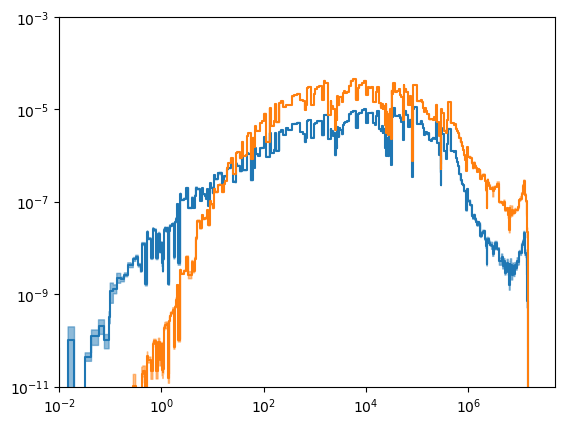

0.0005856097409068312 0.0021594204905854672


In [5]:
fig, ax = plt.subplots()
ax.fill_between(ebins, iter_spectrum_mean - 1*iter_spectrum_stddev, iter_spectrum_mean + 3*iter_spectrum_stddev, step='pre', color='tab:blue', alpha=.5)
ax.plot(ebins, iter_spectrum_mean, lw=2, ls='-', c='tab:blue', drawstyle='steps-pre', label='iter-class')
ax.fill_between(ebins, arc_spectrum_mean - 1*arc_spectrum_stddev, arc_spectrum_mean + 3*arc_spectrum_stddev, step='pre', color='tab:orange', alpha=.5)
ax.plot(ebins, arc_spectrum_mean, lw=2, ls='--', c='tab:orange', drawstyle='steps-pre', label='arc-class')
ax.set_xlim(1e-1, 2e7), ax.set_ylim(1e-11, 1e-1)
ax.set_xscale('log'), ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel('Energy [eV]', fontsize=12)
ax.set_ylabel('Neutron flux [neutron/src]', fontsize=12)
# plt.savefig('spectra_compared.png', dpi=600)
plt.plot()

/tmp/ipykernel_6238/1006810897.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
/tmp/ipykernel_6238/1006810897.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])


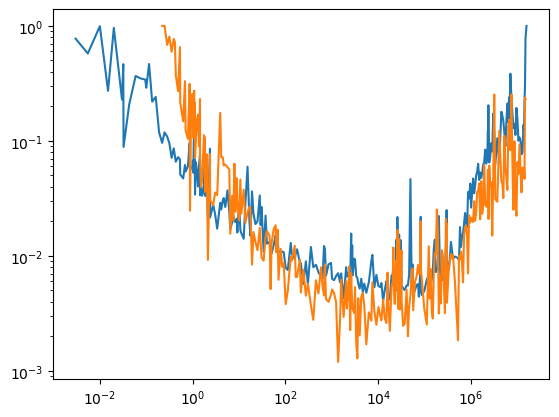

In [6]:
plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])